<h1 align="center"> Statistics and Financial Data Analysis </h1>




SARIMA Models Continuation
===

In [11]:
%reset -f

In [12]:
#import pandas_datareader as pd_data
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import seaborn as sns
import math as m
import scipy as sp
from statsmodels.stats.anova import anova_lm
import pandas_datareader as pd_data

In [13]:
# Importing the Time Series Analysis module for simulating data
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARMAResults
from statsmodels.tsa.stattools import arma_order_select_ic
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.tsa.stattools as sm_tools

In [14]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import pmdarima as pm 
from datetime import datetime
# For splines
import patsy
from patsy import dmatrix

In [40]:
# Will fix figure size for this notebook
plt.rcParams["figure.figsize"] = (8,6)

#Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [56]:
def plot_diagnosticsTight3(data):

    fig, ((ax1,ax2),(ax3,ax4), (ax5,ax6)) = plt.subplots(3,2,figsize=(10,10))
    
    ax1.hist(data, bins =40,color='m', density = True)  
    mu = data.mean()
    sigma = data.std()
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 2419)
    ax1.plot(x, stats.norm.pdf(x, mu, sigma), linewidth= 5)
    ax1.grid()
    ax1.set_title("Hist Resid")
    
    ax2.plot(data)
    ax2.grid()
    ax2.set_title("Data")
    
    fig = plot_acf(data,lags=40,zero=False, ax = ax3,use_vlines = True)
    ax3.grid()
    
    #logData = np.floor(np.log(len(data)))
    ljbox_test = sm.stats.acorr_ljungbox(data,10)#package version
    
    ax4.plot(ljbox_test[1])
    ax4.axhline(y=0.05, color='r',ls='--')
    ax4.set_title("LB test")
    ax4.grid()
    
    fig = sm.qqplot(data, line='q', ax = ax5)
    ax5.grid()
    
    ax6.plot(data*data)
    ax6.grid()
    ax6.set_title("Data Sqr")
    
    plt.tight_layout()

Example of AR(1) model as MA($\infty$)
===

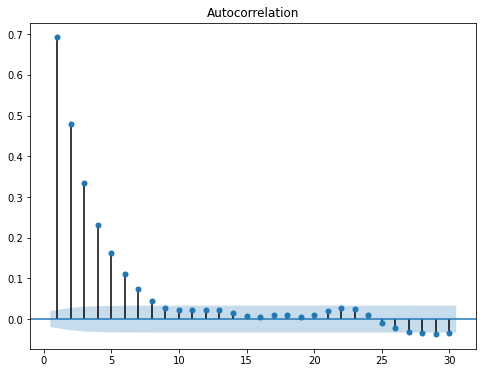

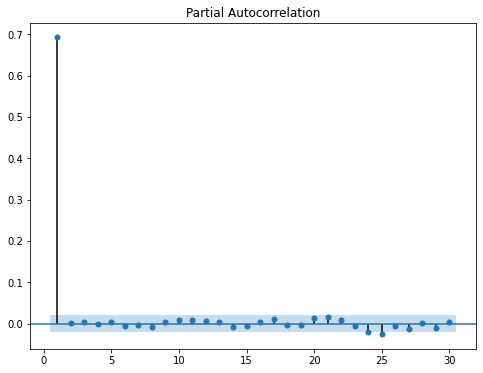

In [158]:
# Here we see in practice how an AR process can be viewed as an MA(infty) process
# For that, we need to create an MA process wiht many parameters, so lets pass an array of coefficients
# to the ArmaProcess generator

#MA coefficients up to 30!
ma_params = np.zeros(30)
for i in range(30):
    ma_params[i] = 0.7**i
    
ar1 = np.array([1]) #The input is inserted as negative in function 
result1 = ArmaProcess(ar1, ma_params)
data_ma_infty = result1.generate_sample(nsample=10000)

plot_acf(data_ma_infty, lags = 30, zero = 0)
plt. show()
plot_pacf(data_ma_infty, lags = 30, zero = 0)
plt. show()

AR with Linear Trend
===

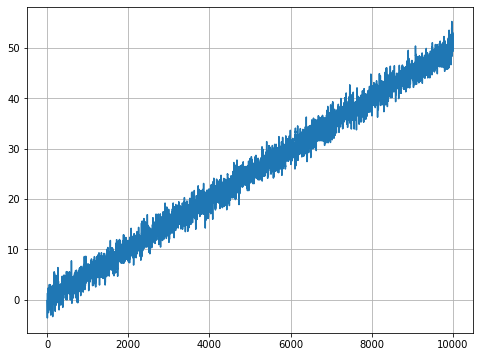

In [209]:
trendAR = np.zeros(10000)
for i in range(10000):
    trendAR[i] = data_ma_infty[i] + i*0.005

plt.plot(trendAR)
plt.grid()

AR with Linear Trend - not stationary
==

In [210]:
# Not Rejecgted Unit Root
test = adfuller(trendAR, maxlag = 5)
print('ADF Statistic: %f' % test[0])
print('p-value: %f' % test[1])
print('Critical Values:i/')
for item, value in test[4].items():
    print('\t%s: %.2f' % (item, value))

ADF Statistic: -2.133693
p-value: 0.231184
Critical Values:i/
	1%: -3.43
	5%: -2.86
	10%: -2.57


In [212]:
# Stationarity is rejected - the data is trend stationary, but not stationary
num = len(trendAR)
maxLag = np.log(num)
test = kpss(trendAR, lags = int(maxLag)) 
print('KPSS Statistic: %f' % test[0])
print('p-value: %f' % test[1])
print('Critical Values:')
for item, value in test[3].items():
    print('\t%s: %.2f' % (item, value))

KPSS Statistic: 99.666157
p-value: 0.010000
Critical Values:
	10%: 0.35
	5%: 0.46
	2.5%: 0.57
	1%: 0.74


In [196]:
# It allows for test with trends - that is, if accounting for trend, is the remainder of the data stationary.

num = len(trendAR)
maxLag = np.log(num)
test = kpss(trendAR, lags = int(maxLag), regression ='ct') 
print('KPSS Statistic: %f' % test[0])
print('p-value: %f' % test[1])
print('Critical Values:')
for item, value in test[3].items():
    print('\t%s: %.2f' % (item, value))

KPSS Statistic: 0.099421
p-value: 0.100000
Critical Values:
	10%: 0.12
	5%: 0.15
	2.5%: 0.18
	1%: 0.22


The Difference of the Linear Trend Series is Stationary
===

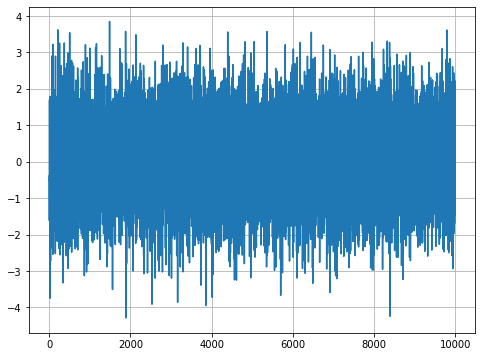

In [167]:
trendAR_diff = np.zeros(9999)
for i in range(1, 10000):
    trendAR_diff[i-1] = data_ma_infty[i] - data_ma_infty[i-1]

plt.plot(trendAR_diff)
plt.grid()

In [187]:
# Reject Unit Root
test = adfuller(trendAR_diff, maxlag = 5)
print('ADF Statistic: %f' % test[0])
print('p-value: %f' % test[1])
print('Critical Values:i/')
for item, value in test[4].items():
    print('\t%s: %.2f' % (item, value))

ADF Statistic: -56.257154
p-value: 0.000000
Critical Values:i/
	1%: -3.43
	5%: -2.86
	10%: -2.57


In [188]:
# Stationarity is NOT rejected
num = len(trendAR_diff)
maxLag = np.log(num)
test = kpss(trendAR_diff, lags = int(maxLag)) 
print('KPSS Statistic: %f' % test[0])
print('p-value: %f' % test[1])
print('Critical Values:')
for item, value in test[3].items():
    print('\t%s: %.2f' % (item, value))

KPSS Statistic: 0.000513
p-value: 0.100000
Critical Values:
	10%: 0.35
	5%: 0.46
	2.5%: 0.57
	1%: 0.74


AR with Seasonal Trend
==

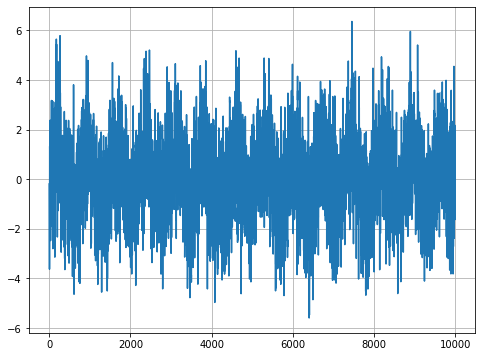

In [191]:
seasAR = np.zeros(10000)
for i in range(10000):
    seasAR[i] = data_ma_infty[i] + np.sin(2*np.pi*i*0.5/365)

plt.plot(seasAR)
plt.grid()


In [192]:
# Reject Unit Root
test = adfuller(seasAR, maxlag = 5)
print('ADF Statistic: %f' % test[0])
print('p-value: %f' % test[1])
print('Critical Values:i/')
for item, value in test[4].items():
    print('\t%s: %.2f' % (item, value))

ADF Statistic: -24.763582
p-value: 0.000000
Critical Values:i/
	1%: -3.43
	5%: -2.86
	10%: -2.57


In [193]:
# Stationarity is NOT rejected
num = len(seasAR)
maxLag = np.log(num)
test = kpss(seasAR, lags = int(maxLag)) 
print('KPSS Statistic: %f' % test[0])
print('p-value: %f' % test[1])
print('Critical Values:')
for item, value in test[3].items():
    print('\t%s: %.2f' % (item, value))

KPSS Statistic: 0.136668
p-value: 0.100000
Critical Values:
	10%: 0.35
	5%: 0.46
	2.5%: 0.57
	1%: 0.74


In [201]:
test1 = pm.auto_arima(data_ma_infty, trace=True,seasonal=False,with_intercept=False,d=0)
print(test1.summary())

Fit ARIMA: order=(2, 0, 2); AIC=28588.088, BIC=28624.140, Fit time=2.019 seconds
Fit ARIMA: order=(0, 0, 0); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0); AIC=28582.090, BIC=28596.510, Fit time=0.019 seconds
Fit ARIMA: order=(0, 0, 1); AIC=30671.139, BIC=30685.560, Fit time=0.040 seconds
Fit ARIMA: order=(2, 0, 0); AIC=28584.088, BIC=28605.719, Fit time=0.033 seconds
Fit ARIMA: order=(1, 0, 1); AIC=28584.088, BIC=28605.719, Fit time=1.241 seconds
Fit ARIMA: order=(2, 0, 1); AIC=28586.089, BIC=28614.931, Fit time=1.627 seconds
Total fit time: 4.980 seconds
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                10000
Model:                     ARMA(1, 0)   Log Likelihood              -14289.045
Method:                       css-mle   S.D. of innovations              1.010
Date:                Wed, 25 Nov 2020   AIC                          28582.090
Time:                 

Seasonality with AEMO Data
===

In [269]:
AEMO = pd.read_csv('AEMOPriceDataSimple.csv', index_col = 0)
SydTemp = pd.read_csv('SydTemp.csv', index_col = 0)
SydTemp.head()

,Bureau of Meteorology station number,Year,Month,Day,Maximum temperature (Degree C),Minimum temperature (Degree C)
Product code,,,,,,
IDCJAC0010,66062.0,1859.0,1.0,1.0,24.4,14.5
IDCJAC0010,66062.0,1859.0,1.0,2.0,24.4,15.7
IDCJAC0010,66062.0,1859.0,1.0,3.0,24.2,15.3
IDCJAC0010,66062.0,1859.0,1.0,4.0,24.7,17.4
IDCJAC0010,66062.0,1859.0,1.0,5.0,24.6,16.9


In [270]:
# 1) Slice SydTemp data frame to select years 2013 and 2014, crating oneYearTemp and nextYearTemp
# 2) Display result

oneYearTemp = SydTemp[SydTemp['Year']==2013]
nextYearTemp = SydTemp[SydTemp['Year']==2014]
nextYearTemp.head()

,Bureau of Meteorology station number,Year,Month,Day,Maximum temperature (Degree C),Minimum temperature (Degree C)
Product code,,,,,,
IDCJAC0010,66062.0,2014.0,1.0,1.0,27.1,20.5
IDCJAC0010,66062.0,2014.0,1.0,2.0,36.5,22.3
IDCJAC0010,66062.0,2014.0,1.0,3.0,26.2,21.0
IDCJAC0010,66062.0,2014.0,1.0,4.0,27.5,20.1
IDCJAC0010,66062.0,2014.0,1.0,5.0,26.0,20.8


In [271]:
# 1) Select for oneYearTemp max and min temperature and get mean temp, storying under meanTemp
# 2) Display your df

maxTemp = oneYearTemp['Maximum temperature (Degree C)']
minTemp = oneYearTemp['Minimum temperature (Degree C)']
meanTemp = (maxTemp + minTemp)*0.5
len(meanTemp)

365

In [272]:
# 1) Select for nextYearTemp max and min temperature and get mean temp, storying under meanTemp
# 2) Display your df

nextYearTemp = SydTemp[SydTemp['Year']==2014]
maxTempNext = nextYearTemp['Maximum temperature (Degree C)']
minTempNext = nextYearTemp['Minimum temperature (Degree C)']
meanTempNext = (maxTempNext + minTempNext)*0.5
meanTempNext.values[0]

23.8

In [273]:
# Now get year from oneYearTemp and store it in variabel 'year', display

#names = ['date','meanTemp']

N = len(oneYearTemp)
dt = []
year = oneYearTemp.iloc[0][1]
type(year)

numpy.float64

In [274]:
# Convert dates in data frame to datetime

for i in range(N):
    month = oneYearTemp.iloc[i][2]
    day = oneYearTemp.iloc[i][3]
    dt.append(datetime(year=int(year), month = int(month), day= int(day)))

In [275]:
# Now create a dataframe with your datetime data and your meanTemp values
# Remember to set the index to the datetime column
# display

myList = [dt, meanTemp.values]
myNames = ['date','meanTemp']
myDict = dict(zip(myNames, myList))
dfMeanTemp = pd.DataFrame({ key:pd.Series(value) for key, value in myDict.items()})

In [276]:
dfMeanTemp.head()

,date,meanTemp
0,2013-01-01,23.20
1,2013-01-02,21.60
2,2013-01-03,21.60
3,2013-01-04,22.45
4,2013-01-05,24.60


In [277]:
dfMeanTemp.set_index(dfMeanTemp['date'], inplace = True)
dfMeanTemp.head()
del dfMeanTemp['date']

In [278]:
dfMeanTemp.head()

,meanTemp
date,
2013-01-01,23.20
2013-01-02,21.60
2013-01-03,21.60
2013-01-04,22.45
2013-01-05,24.60


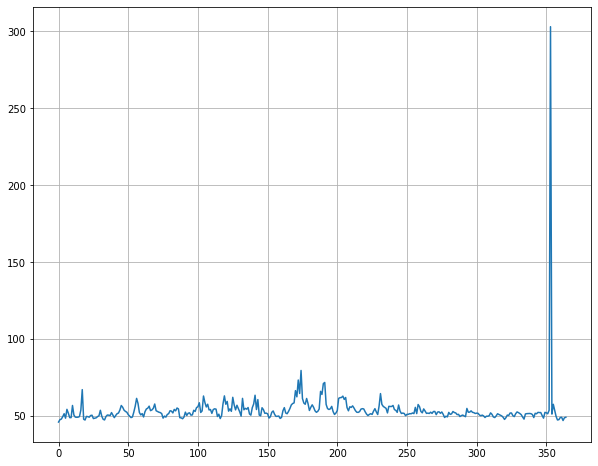

In [279]:
plt.figure(1, figsize=(10,8))
plt.plot(AEMO['RRP'].values)
plt.grid()
plt.show()

In [280]:
# Remove outlier
AEMO[AEMO['RRP']==AEMO['RRP'].max()]=AEMO['RRP'].mean()

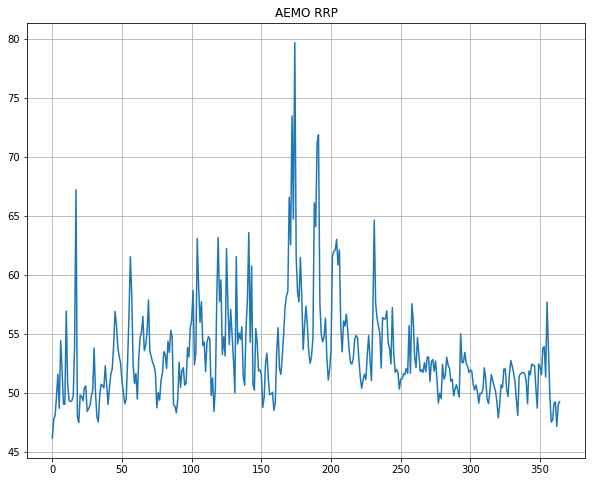

In [281]:
plt.figure(1, figsize=(10,8))
plt.plot(AEMO['RRP'].values)
plt.title("AEMO RRP")
plt.grid()
plt.savefig("AEMORRP")

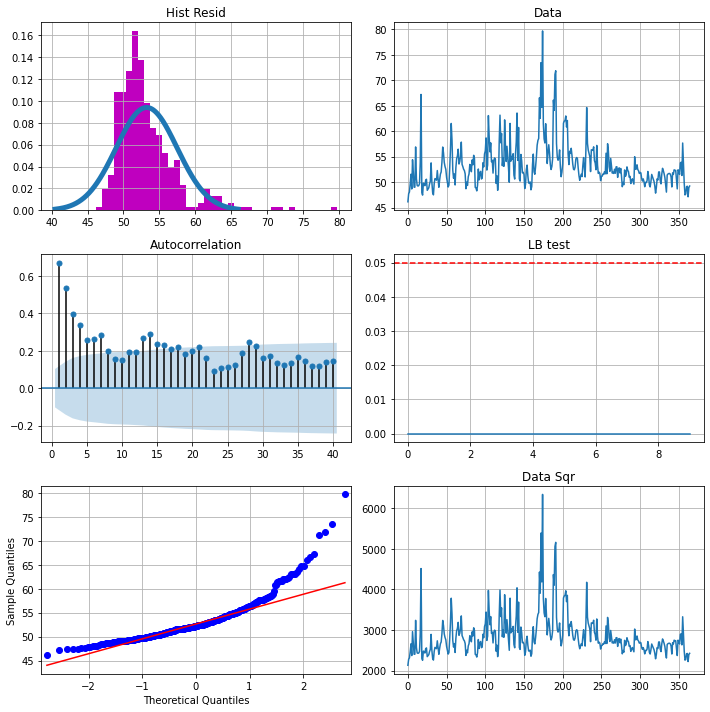

In [282]:
# Check characteristics of process

price = AEMO['RRP'].values
plot_diagnosticsTight3(price)

In [283]:
# Reject Unit Root
test = adfuller(price, maxlag = 5)
print('ADF Statistic: %f' % test[0])
print('p-value: %f' % test[1])
print('Critical Values:i/')
for item, value in test[4].items():
    print('\t%s: %.2f' % (item, value))

ADF Statistic: -6.619747
p-value: 0.000000
Critical Values:i/
	1%: -3.45
	5%: -2.87
	10%: -2.57


In [284]:
# But Stationarity is rejected.
num = len(price)
maxLag = np.log(num)
test = kpss(price, lags = int(maxLag)) 
print('KPSS Statistic: %f' % test[0])
print('p-value: %f' % test[1])
print('Critical Values:')
for item, value in test[3].items():
    print('\t%s: %.2f' % (item, value))

KPSS Statistic: 0.714742
p-value: 0.012205
Critical Values:
	10%: 0.35
	5%: 0.46
	2.5%: 0.57
	1%: 0.74


Examples for Creating Factors and Carrying out Analysis Accordingly
===

In [324]:
# Create data frames to combine relevant variables for analysis.
N = len(price)
weekly = np.zeros(N)
weekly2 = np.zeros(N)
yearly = np.zeros(N)
yearly2 = np.zeros(N)
meanTempV = np.zeros(N)

for i in range(N):
    yearly[i] = np.sin(2*np.pi*i/30)
    yearly2[i] = np.cos(2*np.pi*i/30)
    weekly[i] = np.sin(2*np.pi*i/7)
    weekly2[i] = np.cos(2*np.pi*i/7)
    meanTempV[i] = meanTemp.values[i]
    # Create dataframe
myList = [dfMeanTemp.index, meanTempV, yearly, yearly2, weekly, weekly2]
names = ['date','meanTemp','y1','y2','w1','w2']
myDict = dict(zip(names, myList))
df = pd.DataFrame({ key:pd.Series(value) for key, value in myDict.items()})

df.set_index(df['date'], inplace = True)
df.head()
del df['date']



# Generate data to feed to forecast (required for exogeneous variables)
def df_sincosFit(N):
    weeklyFit = np.zeros(N)
    weekly2Fit = np.zeros(N)
    yearlyFit = np.zeros(N)
    yearly2Fit = np.zeros(N)
    meanTempFit = np.zeros(N)

    for i in range(N):
        yearlyFit[i] = np.sin(2*np.pi*i/30)
        yearly2Fit[i] = np.cos(2*np.pi*i/30)
        weeklyFit[i] = np.sin(2*np.pi*i/7)
        weekly2Fit[i] = np.cos(2*np.pi*i/7)
        if(i < len(meanTempNext)):
            meanTempFit[i] = meanTempNext.values[i]
        else:
            meanTempFit[i] = meanTempNext.values[len(meanTempNext)-1]
    # Create dataframe
    myList = [meanTempFit, yearlyFit, yearly2Fit, weeklyFit, weekly2Fit]
    names = ['meanTempFit','y1Fit','y2Fit','w1Fit','w2Fit']
    myDict = dict(zip(names, myList))
    dfFit = pd.DataFrame({ key:pd.Series(value) for key, value in myDict.items()})
    return dfFit

dfFit = df_sincosFit(20)


In [325]:
df.head()

,meanTemp,y1,y2,w1,w2
date,,,,,
2013-01-01,23.20,0.000000,1.000000,0.000000,1.000000
2013-01-02,21.60,0.207912,0.978148,0.781831,0.623490
2013-01-03,21.60,0.406737,0.913545,0.974928,-0.222521
2013-01-04,22.45,0.587785,0.809017,0.433884,-0.900969
2013-01-05,24.60,0.743145,0.669131,-0.433884,-0.900969


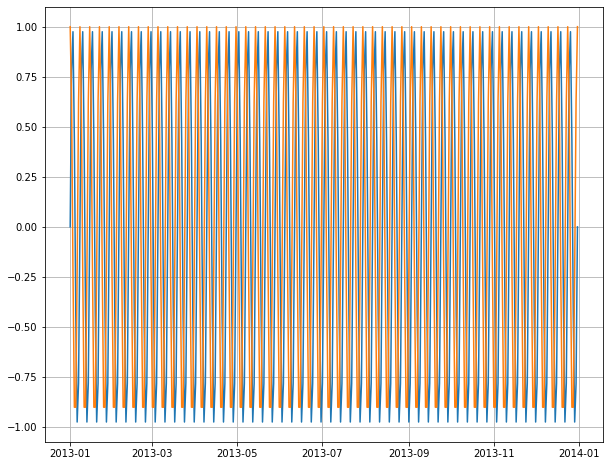

In [326]:
plt.figure(1, figsize=(10,8))
plt.plot(df[['w1','w2']])
plt.grid()
plt.show()

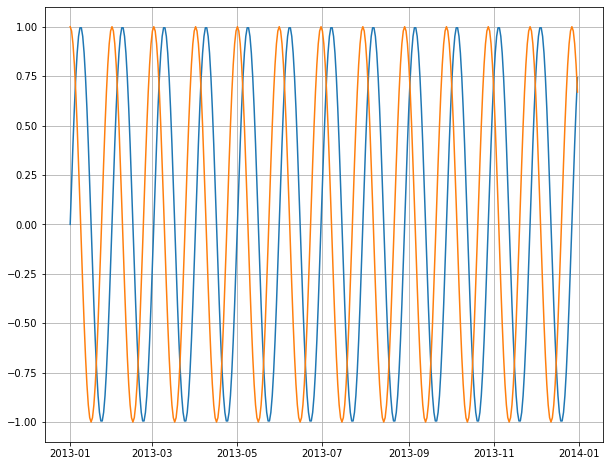

In [327]:
plt.figure(1, figsize=(10,8))
plt.plot(df[['y1','y2']])
plt.grid()
plt.show()

In [329]:
AEMO = pd.read_csv('AEMOPriceDataSimple.csv', index_col = 0)
# Remove outlier
AEMO[AEMO['RRP']==AEMO['RRP'].max()]=AEMO['RRP'].mean()
temp =AEMO.index[2]
print(temp)
print(type(temp))


03/01/13
<class 'str'>


In [330]:
for i in range(0,1):
    temp = AEMO.index[i]
    dt = datetime.strptime(temp, '%d/%m/%y')

In [331]:
#Quickly create cateogry to extract day of the week.

N = len(price)
y_pos = np.zeros(N)
for i in range(N):
    temp =AEMO.index[i]
    dt = datetime.strptime(temp, '%d/%m/%y')
    y_pos[i]= dt.weekday()
AEMO['DayWeek'] = y_pos
AEMO['DayWeek'].astype('category');


In [332]:
AEMO.head(10)

,RRP,DayWeek
Date,,
01/01/13,46.15,1.0
02/01/13,47.72,2.0
03/01/13,48.08,3.0
04/01/13,49.65,4.0
05/01/13,51.56,5.0
06/01/13,48.67,6.0
07/01/13,54.40,0.0
08/01/13,51.93,1.0
09/01/13,49.02,2.0


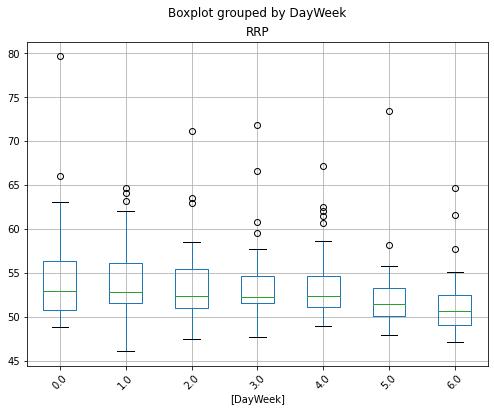

In [333]:
AEMO.boxplot(by='DayWeek',rot=45, fontsize=10)
plt.savefig("BoxAEMO_Week")

In [334]:
del AEMO['DayWeek']

In [335]:
print(pd.Timestamp(AEMO.index[2]))

2013-03-01 00:00:00


In [336]:
AEMO.head(5)

,RRP
Date,
01/01/13,46.15
02/01/13,47.72
03/01/13,48.08
04/01/13,49.65
05/01/13,51.56


It makes sense to analyse temperature data by grouping by Months
===

In [337]:
# dt is the Datetime object - this is one way to get all methods:
dt.__dir__()

['__repr__',
 '__hash__',
 '__str__',
 '__getattribute__',
 '__lt__',
 '__le__',
 '__eq__',
 '__ne__',
 '__gt__',
 '__ge__',
 '__add__',
 '__radd__',
 '__sub__',
 '__rsub__',
 '__new__',
 'now',
 'utcnow',
 'fromtimestamp',
 'utcfromtimestamp',
 'strptime',
 'combine',
 'date',
 'time',
 'timetz',
 'ctime',
 'timetuple',
 'timestamp',
 'utctimetuple',
 'isoformat',
 'utcoffset',
 'tzname',
 'dst',
 'replace',
 'astimezone',
 '__reduce_ex__',
 '__reduce__',
 'hour',
 'minute',
 'second',
 'microsecond',
 'tzinfo',
 'fold',
 '__doc__',
 'min',
 'max',
 'resolution',
 'fromordinal',
 'today',
 'strftime',
 '__format__',
 'isocalendar',
 'isoweekday',
 'toordinal',
 'weekday',
 'year',
 'month',
 'day',
 '__setattr__',
 '__delattr__',
 '__init__',
 '__subclasshook__',
 '__init_subclass__',
 '__sizeof__',
 '__dir__',
 '__class__']

In [338]:
# Or use "tab" to display methods
# dt. 

In [339]:
#Quickly create cateogry to extract day of the week.

N = len(price)
y_pos = np.zeros(N)
for i in range(N):
    temp =AEMO.index[i]
    dt = datetime.strptime(temp, '%d/%m/%y')
    y_pos[i]= dt.month
AEMO['Month'] = y_pos
AEMO['Month'].astype('category');
AEMO.tail()

,RRP,Month
Date,,
27/12/13,49.10,12.0
28/12/13,49.21,12.0
29/12/13,47.13,12.0
30/12/13,48.94,12.0
31/12/13,49.24,12.0


This is a super nice plot to show Heteroskedasticity of residuals and how there appears to be seasonality
===

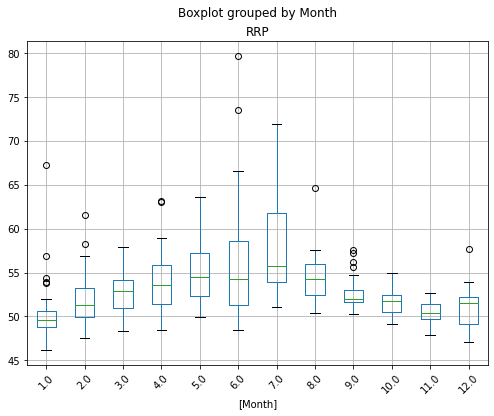

In [340]:
AEMO.boxplot(by='Month',rot=45, fontsize=10);
plt.savefig("Boxplot_AEMO_MONTH")

In [341]:
N = len(dfMeanTemp)
y_pos = np.zeros(N)
for i in range(N):
    temp =dfMeanTemp.index[i]
    y_pos[i]= temp.month
dfMeanTemp['Month'] = y_pos
dfMeanTemp['Month'].astype('category');
dfMeanTemp.tail(5)

,meanTemp,Month,fitted
date,,,
2013-12-27,21.35,12.0,51.351814
2013-12-28,22.45,12.0,50.863769
2013-12-29,22.30,12.0,50.930321
2013-12-30,21.50,12.0,51.285262
2013-12-31,21.85,12.0,51.129975


In [347]:
X1 = dfMeanTemp[['meanTemp','Month']]
X1 = sm.add_constant(X1)
y = price
model = sm.OLS(y, X1)
lm = model.fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.170
Model:                            OLS   Adj. R-squared:                  0.165
Method:                 Least Squares   F-statistic:                     37.06
Date:                Wed, 25 Nov 2020   Prob (F-statistic):           2.27e-15
Time:                        16:17:46   Log-Likelihood:                -1011.8
No. Observations:                 365   AIC:                             2030.
Df Residuals:                     362   BIC:                             2041.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         62.9953      1.169     53.870      0.0

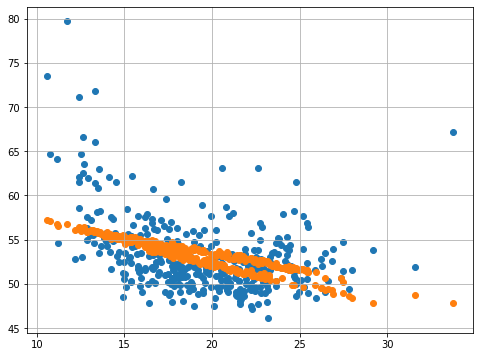

In [348]:
fitted = lm.fittedvalues
dfMeanTemp['fitted'] = fitted
plt.scatter(dfMeanTemp['meanTemp'],price)
plt.scatter(dfMeanTemp['meanTemp'],dfMeanTemp['fitted'])
plt.grid()

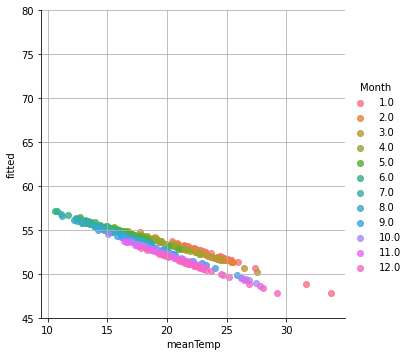

In [349]:
import seaborn as sns
lmplot = sns.lmplot('meanTemp', 'fitted', data=dfMeanTemp, hue='Month', fit_reg=False)
axes = lmplot.axes
axes[0,0].set_ylim(45,80)

plt.grid()
plt.show()

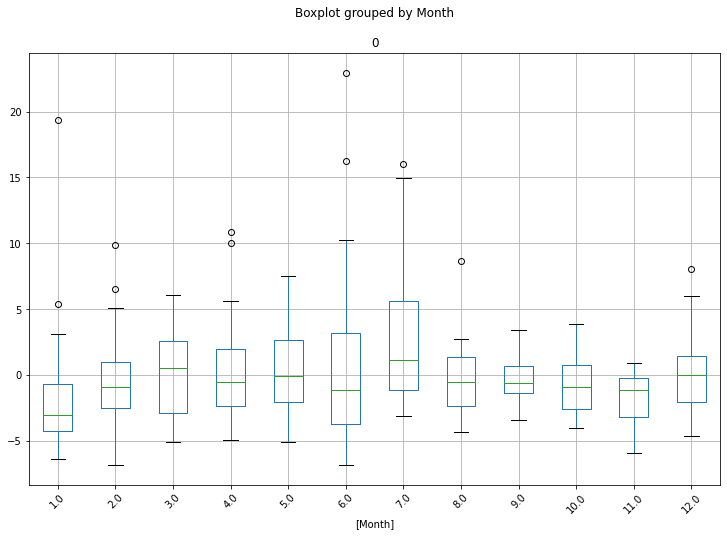

In [350]:
N = len(lm.resid)
y_pos = np.zeros(N)

temp = lm.resid.to_frame()

for i in range(N):
    y_pos[i]= lm.resid.index[i].month
temp['Month'] = y_pos
temp['Month'].astype('category');
temp.head(20)

temp.boxplot(by='Month',rot=45, fontsize=10,figsize=(12,8));

Examples of using periodic functions like Sin and Cos to model seasonality
===

In [351]:
# Fit a linear regression

X1 = df[['meanTemp','y1','y2']]
X1 = sm.add_constant(X1)
y = price
model = sm.OLS(y, X1)
lm = model.fit()
y_fitted= lm.fittedvalues
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.175
Model:                            OLS   Adj. R-squared:                  0.168
Method:                 Least Squares   F-statistic:                     25.58
Date:                Wed, 25 Nov 2020   Prob (F-statistic):           5.02e-15
Time:                        16:17:57   Log-Likelihood:                -1010.6
No. Observations:                 365   AIC:                             2029.
Df Residuals:                     361   BIC:                             2045.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         61.2665      1.015     60.377      0.0

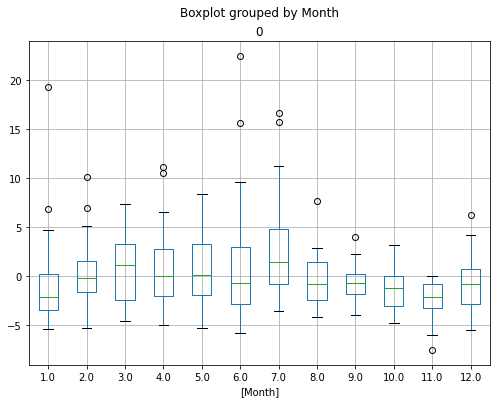

In [352]:

N = len(lm.resid)
y_pos = np.zeros(N)

temp = lm.resid.to_frame()

for i in range(N):
    y_pos[i]= lm.resid.index[i].month
temp['Month'] = y_pos
temp['Month'].astype('category');
temp.head(20)

temp.boxplot(by='Month')



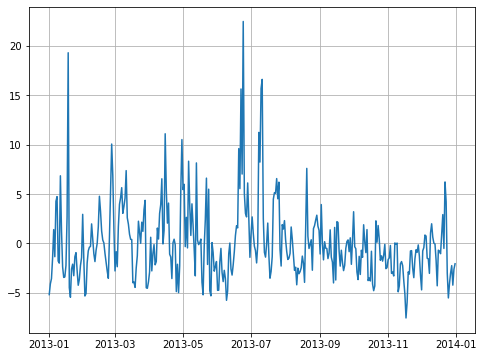

In [353]:
plt.plot(lm.resid)
plt.grid()
plt.show()

In [354]:
# reject unit root
test = adfuller(lm.resid, maxlag = 7)
print('ADF Statistic: %f' % test[0])
print('p-value: %f' % test[1])
print('Critical Values:i/')
for item, value in test[4].items():
    print('\t%s: %.2f' % (item, value))

ADF Statistic: -5.491100
p-value: 0.000002
Critical Values:i/
	1%: -3.45
	5%: -2.87
	10%: -2.57


In [355]:
# cannot reject stationarity 
test = kpss(lm.resid, lags=5) 
print('KPSS Statistic: %f' % test[0])
print('p-value: %f' % test[1])
print('Critical Values:')
for item, value in test[3].items():
    print('\t%s: %.2f' % (item, value))

KPSS Statistic: 0.554006
p-value: 0.029503
Critical Values:
	10%: 0.35
	5%: 0.46
	2.5%: 0.57
	1%: 0.74


In [176]:
# Fitting seasonal functions as regression external factors in conjunction with ARIMA.

model = ARIMA(price, exog = df[['y1','y2']], order=(1,0,2))
results = model.fit()
print(results.summary());

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  365
Model:                     ARMA(1, 2)   Log Likelihood                -920.711
Method:                       css-mle   S.D. of innovations              3.013
Date:                Wed, 25 Nov 2020   AIC                           1855.422
Time:                        13:55:42   BIC                           1882.721
Sample:                    01-01-2013   HQIC                          1866.271
                         - 12-31-2013                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         53.2009      0.380    140.022      0.000      52.456      53.946
y1             0.5568      0.539      1.033      0.302      -0.500       1.613
y2            -2.9953      0.535     -5.599      0.0

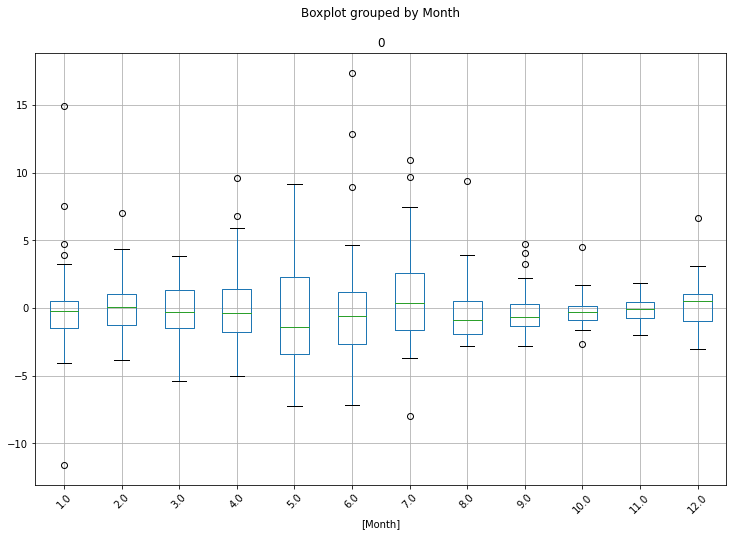

In [177]:

N = len(results.resid)
y_pos = np.zeros(N)

temp = results.resid.to_frame()

for i in range(N):
    y_pos[i]= results.resid.index[i].month
temp['Month'] = y_pos
temp['Month'].astype('category');
temp.head(20)

temp.boxplot(by='Month',rot=45, fontsize=10,figsize=(12,8));



In [178]:
# reject unit root
test = adfuller(lm.resid, maxlag = 7)
print('ADF Statistic: %f' % test[0])
print('p-value: %f' % test[1])
print('Critical Values:i/')
for item, value in test[4].items():
    print('\t%s: %.2f' % (item, value))

ADF Statistic: -4.565432
p-value: 0.000150
Critical Values:i/
	1%: -3.45
	5%: -2.87
	10%: -2.57


In [179]:
# cannot reject stationarity 
test = kpss(lm.resid, lags=5) 
print('KPSS Statistic: %f' % test[0])
print('p-value: %f' % test[1])
print('Critical Values:')
for item, value in test[3].items():
    print('\t%s: %.2f' % (item, value))

KPSS Statistic: 0.364485
p-value: 0.092463
Critical Values:
	10%: 0.35
	5%: 0.46
	2.5%: 0.57
	1%: 0.74


365


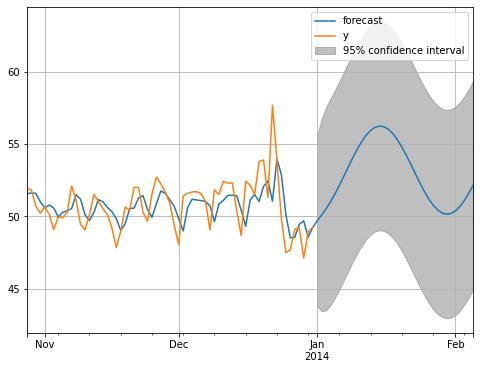

In [181]:
lastIdx = len(results.fittedvalues)
print(lastIdx)

# I need to create data to feed into exogenous matrix to be used for prediction:

startPt = 300
endPt = 400
nForecast = endPt - lastIdx
exog = df_sincosFit(nForecast + 1)


# This will proeduce the insampling, 
# one-step prediction (fitted values) in addtion to one-step prediciton (mean)
# The mean is not constant! As we are overlayign it with the sin/cos periodic functions.

results.plot_predict(start=startPt,end=endPt , exog = exog[['y1Fit','y2Fit']], dynamic = False)
plt.grid()
plt.show()

In [99]:
# Fitting seasonal functions as regression external factors in conjunction with ARIMA.

# No temperature 

model = ARIMA(price, exog = df[['w1','w2']], order=(1,0,1))
resultsARIMA = model.fit()
print(resultsARIMA.summary());

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  365
Model:                     ARMA(1, 1)   Log Likelihood                -922.587
Method:                       css-mle   S.D. of innovations              3.027
Date:                Wed, 25 Nov 2020   AIC                           1857.175
Time:                        13:10:50   BIC                           1880.574
Sample:                    01-01-2013   HQIC                          1866.474
                         - 12-31-2013                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         53.0768      0.651     81.488      0.000      51.800      54.353
w1             0.6449      0.237      2.721      0.007       0.180       1.109
w2             0.8017      0.236      3.391      0.0

In [100]:
resultsARIMA.cov_params()

,const,w1,w2,ar.L1.y,ma.L1.y
const,0.424251,3.199730e-06,-1.357030e-03,-0.001656,0.001728
w1,0.000003,5.617892e-02,-1.797918e-07,-0.000008,0.000053
w2,-0.001357,-1.797918e-07,5.588257e-02,0.000146,-0.000147
ar.L1.y,-0.001656,-7.863783e-06,1.464022e-04,0.001759,-0.002093
ma.L1.y,0.001728,5.279807e-05,-1.468556e-04,-0.002093,0.004989


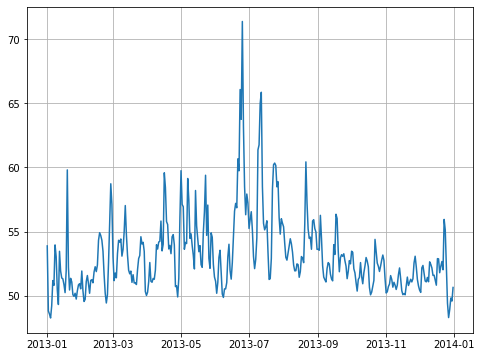

In [101]:
plt.plot(resultsARIMA.fittedvalues)
plt.grid()
plt.show()

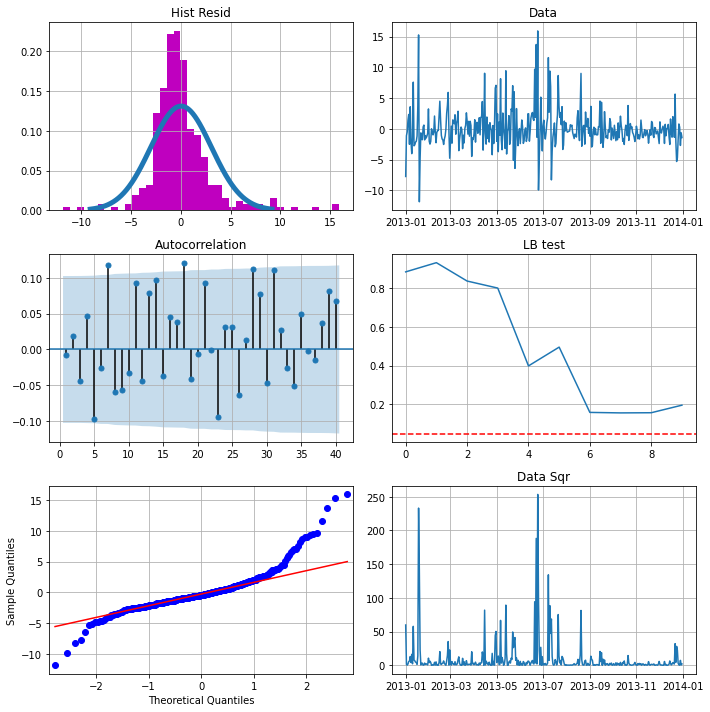

In [102]:
plot_diagnosticsTight3(resultsARIMA.resid)

365


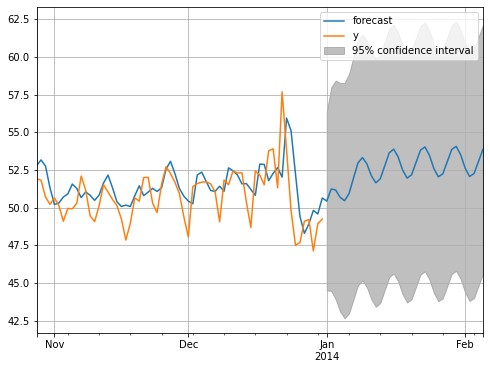

In [103]:
lastIdx = len(resultsARIMA.fittedvalues)
print(lastIdx)

# I need to create data to feed into exogenous matrix to be used for prediction:

startPt = 300
endPt = 400
nForecast = endPt - lastIdx
exog = df_sincosFit(nForecast+1)


# This will proeduce the insampling, 
# one-step prediction (fitted values) in addtion to one-step prediciton (mean)
# The mean is not constant! As we are overlayign it with the sin/cos periodic functions.

resultsARIMA.plot_predict(start=startPt,end=endPt , exog = exog[['w1Fit','w2Fit']])
plt.grid()
plt.show()

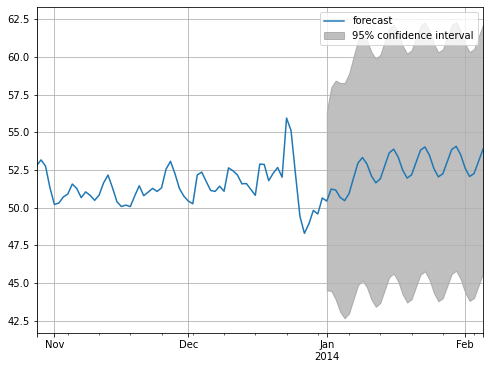

In [93]:
resultsARIMA.plot_predict(start=startPt,end=endPt , exog = exog[['w1Fit','w2Fit']], plot_insample = False)
plt.grid()
plt.show()

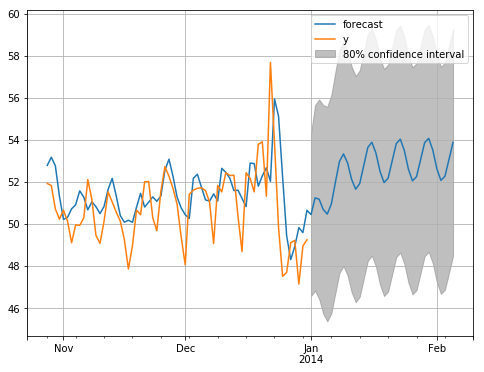

In [68]:
resultsARIMA.plot_predict(start=startPt,end=endPt , exog = exog[['w1Fit','w2Fit']],alpha = 0.2)
plt.grid()
plt.show()

365
35


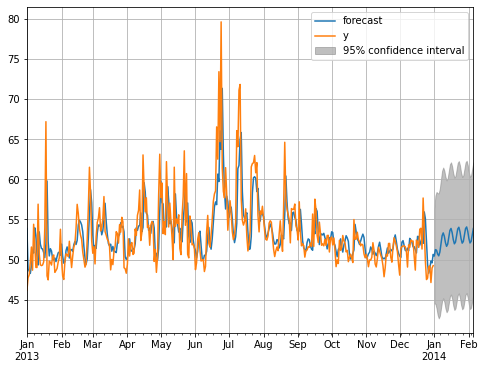

In [104]:
# I need to create data to feed into exogenous matrix to be used for prediction:
lastIdx = len(resultsARIMA.fittedvalues)
print(lastIdx)
startPt = 0
endPts = 400
nForecast = int(endPts - lastIdx)
print(nForecast)
exog = df_sincosFit(nForecast+1) # needs to add 

resultsARIMA.plot_predict(start=startPt,end=endPt , exog = exog[['w1Fit','w2Fit']])
plt.grid()
plt.show()

Bringing it all together - mean temperature, weekly trends, yearly
===

In [105]:
# Fitting seasonal functions (weekly and yearly) and mean temperature as regression external factors in conjunction with ARIMA.

results = pm.auto_arima(price,trace = True, d=0, seasonal=False, with_intercept=True, exogenous = df[['meanTemp','y1','y2','w1','w2']]) #d = 1

Fit ARIMA: order=(2, 0, 2); AIC=1843.789, BIC=1886.688, Fit time=0.436 seconds
Fit ARIMA: order=(0, 0, 0); AIC=1984.789, BIC=2012.089, Fit time=0.013 seconds
Fit ARIMA: order=(1, 0, 0); AIC=1846.542, BIC=1877.741, Fit time=0.165 seconds
Fit ARIMA: order=(0, 0, 1); AIC=1898.004, BIC=1929.203, Fit time=0.120 seconds
Fit ARIMA: order=(1, 0, 2); AIC=1842.623, BIC=1881.622, Fit time=0.285 seconds
Fit ARIMA: order=(1, 0, 1); AIC=1842.040, BIC=1877.139, Fit time=0.239 seconds
Fit ARIMA: order=(2, 0, 1); AIC=1841.995, BIC=1880.994, Fit time=0.303 seconds
Fit ARIMA: order=(2, 0, 0); AIC=1840.889, BIC=1875.988, Fit time=0.243 seconds
Fit ARIMA: order=(3, 0, 1); AIC=1843.817, BIC=1886.715, Fit time=0.394 seconds
Fit ARIMA: order=(3, 0, 0); AIC=1842.459, BIC=1881.458, Fit time=0.301 seconds
Total fit time: 2.504 seconds


In [106]:
print(results.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  365
Model:                     ARMA(2, 0)   Log Likelihood                -911.444
Method:                       css-mle   S.D. of innovations              2.938
Date:                Wed, 25 Nov 2020   AIC                           1840.889
Time:                        13:16:08   BIC                           1875.988
Sample:                             0   HQIC                          1854.838
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         50.9931      1.386     36.789      0.000      48.276      53.710
x1             0.1131      0.068      1.659      0.097      -0.021       0.247
x2             0.4638      0.600      0.772      0.4

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  365
Model:                     ARMA(2, 0)   Log Likelihood                -911.444
Method:                       css-mle   S.D. of innovations              2.938
Date:                Wed, 25 Nov 2020   AIC                           1840.889
Time:                        13:16:35   BIC                           1875.988
Sample:                    01-01-2013   HQIC                          1854.838
                         - 12-31-2013                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         50.9931      1.386     36.789      0.000      48.276      53.710
meanTemp       0.1131      0.068      1.659      0.097      -0.021       0.247
y1             0.4638      0.600      0.772      0.4

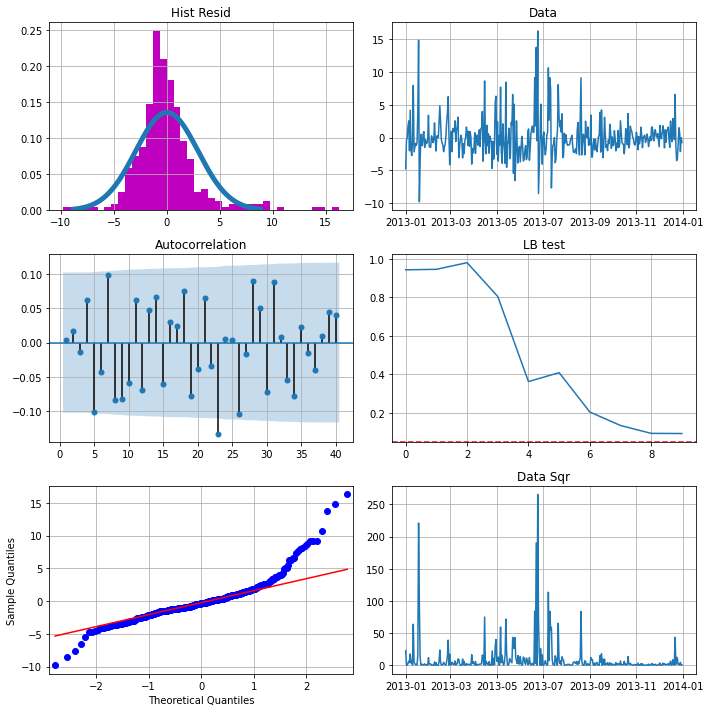

In [107]:
# Fitting seasonal functions as regression external factors in conjunction with ARIMA.

model = ARIMA(price, order=(2,0,0), exog = df[['meanTemp','y1','y2','w1','w2']])
results = model.fit()
print(results.summary());

plot_diagnosticsTight3(results.resid)

Use model to forecast (though we see some limitations...)
===

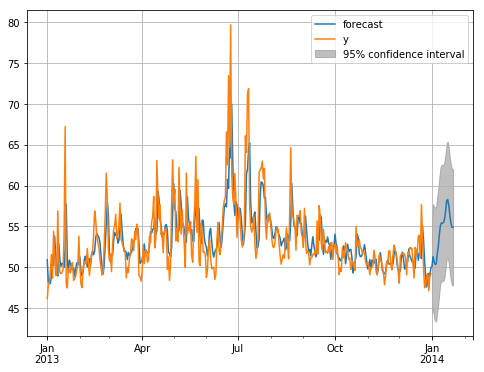

In [73]:
lastIdx = len(results.fittedvalues)
endPts = 385 
startPt = 0
nForecast = endPts - lastIdx
exog = df_sincosFit(nForecast+1) # needs to add 20 points for external regressor to predict.

results.plot_predict(start=0,end=endPts, exog = exog[['meanTempFit','y1Fit','y2Fit','w1Fit','w2Fit']] )
plt.grid()
plt.show()

Using splines to model the transform temperature
===

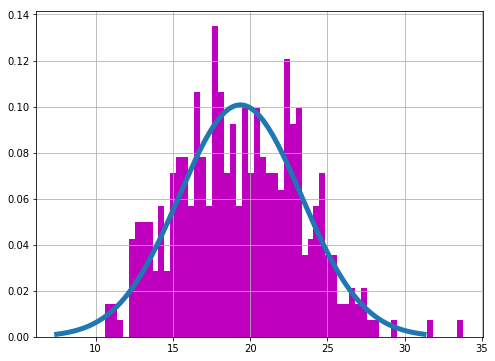

In [74]:
plt.hist(meanTemp.values, bins =60,color='m', density = True)
mu = meanTemp.mean()
sigma = meanTemp.std()
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 2419)
plt.plot(x, stats.norm.pdf(x, mu, sigma), linewidth= 5)
plt.grid()
plt.show()

In [109]:
x = meanTemp
dfree = 6 # degrees of freedom
n = dfree

percentiles = np.asarray([1/n*100,2/n*100,3/n*100,4/n*100, 5/n*100])
knots_6 = np.percentile(x, percentiles)
print(knots_6)
len(price)
meanTemp.values.max()

[15.4        17.51666667 19.25       21.35       23.21666667]


33.75

(365, 4)


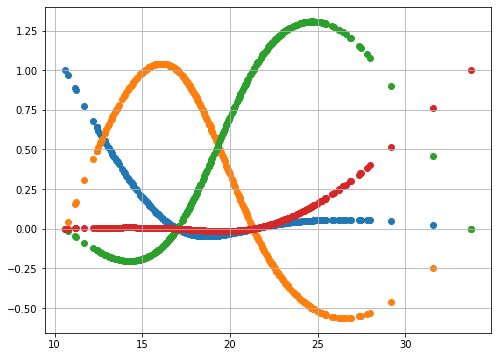

In [110]:
X1 = dmatrix("cr(x, df=4)-1", {"x": x}) #already chooses knots to be equally spaced quartiles.
X1=np.asarray(X1)
ns_p = pd.DataFrame(X1) 
print(X1.shape)

plt.scatter(x, X1[:,0]);
plt.scatter(x, X1[:,1]);
plt.scatter(x, X1[:,2]);
plt.scatter(x, X1[:,3]);


plt.grid()
plt.show()

In [111]:
# Fit a linear regression
X1 = sm.add_constant(X1)
y = price
model = sm.OLS(y, X1)
lm = model.fit()
y_fitted= lm.fittedvalues
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.391
Model:                            OLS   Adj. R-squared:                  0.386
Method:                 Least Squares   F-statistic:                     77.19
Date:                Wed, 25 Nov 2020   Prob (F-statistic):           1.35e-38
Time:                        13:17:55   Log-Likelihood:                -955.32
No. Observations:                 365   AIC:                             1919.
Df Residuals:                     361   BIC:                             1934.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         45.3394      0.391    115.925      0.0

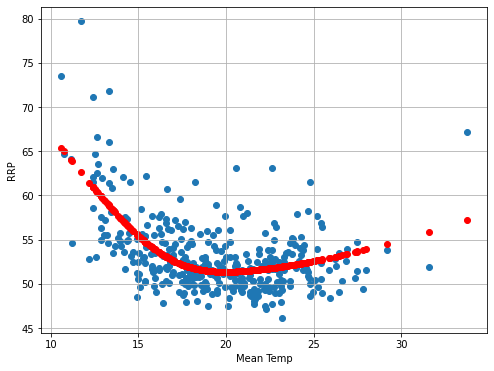

In [112]:
x = meanTemp.values
plt.grid()
plt.scatter(x=x,y=price)
plt.ylabel('RRP')
plt.xlabel('Mean Temp')
plt.scatter(x,y_fitted, color = 'red')
plt.show()

Now compbine seasonality, with natural spline model for mean temperature as regressors for price
===

In [114]:
# Fit a linear regression
df.head()

,meanTemp,y1,y2,w1,w2
date,,,,,
2013-01-01,23.20,0.000000,1.000000,0.000000,1.000000
2013-01-02,21.60,0.017213,0.999852,0.781831,0.623490
2013-01-03,21.60,0.034422,0.999407,0.974928,-0.222521
2013-01-04,22.45,0.051620,0.998667,0.433884,-0.900969
2013-01-05,24.60,0.068802,0.997630,-0.433884,-0.900969


In [115]:
# Add results of natural spline as input data

df['x0'] = X1[:,0]
df['x1'] = X1[:,1]
df['x2'] = X1[:,2]
df['x3'] = X1[:,3]
df['x4'] = X1[:,4]


In [116]:
df.head()

,meanTemp,y1,y2,w1,w2,x0,x1,x2,x3,x4
date,,,,,,,,,,
2013-01-01,23.20,0.000000,1.000000,0.000000,1.000000,1.0,0.035621,-0.347634,1.250994,0.061018
2013-01-02,21.60,0.017213,0.999852,0.781831,0.623490,1.0,0.006601,-0.064423,1.051797,0.006025
2013-01-03,21.60,0.034422,0.999407,0.974928,-0.222521,1.0,0.006601,-0.064423,1.051797,0.006025
2013-01-04,22.45,0.051620,0.998667,0.433884,-0.900969,1.0,0.023709,-0.231379,1.176724,0.030947
2013-01-05,24.60,0.068802,0.997630,-0.433884,-0.900969,1.0,0.050579,-0.493610,1.307396,0.135635


In [120]:
arimaLogRtn = pm.auto_arima(price, trace=True,seasonal=False, with_intercept=False, exogenous = df[['w1','w2','x1','x2','x3','x4']],d=0)

Fit ARIMA: order=(2, 0, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0); AIC=1907.641, BIC=1934.941, Fit time=0.018 seconds
Fit ARIMA: order=(1, 0, 0); AIC=1824.597, BIC=1855.796, Fit time=0.116 seconds
Fit ARIMA: order=(0, 0, 1); AIC=1854.159, BIC=1885.359, Fit time=0.120 seconds
Fit ARIMA: order=(2, 0, 0); AIC=1811.266, BIC=1846.365, Fit time=0.150 seconds
Fit ARIMA: order=(2, 0, 1); AIC=1809.453, BIC=1848.452, Fit time=0.226 seconds
Fit ARIMA: order=(3, 0, 2); AIC=1811.246, BIC=1858.045, Fit time=0.849 seconds
Fit ARIMA: order=(1, 0, 1); AIC=1807.465, BIC=1842.564, Fit time=0.171 seconds
Fit ARIMA: order=(1, 0, 2); AIC=1809.452, BIC=1848.451, Fit time=0.237 seconds
Total fit time: 1.909 seconds


In [121]:
print(arimaLogRtn.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  365
Model:                     ARMA(1, 1)   Log Likelihood                -894.732
Method:                       css-mle   S.D. of innovations              2.806
Date:                Wed, 25 Nov 2020   AIC                           1807.465
Time:                        13:19:36   BIC                           1842.564
Sample:                             0   HQIC                          1821.414
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.6035      0.208      2.903      0.004       0.196       1.011
x2             0.8218      0.206      3.980      0.000       0.417       1.226
x3            60.1917      1.335     45.082      0.0

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  365
Model:                     ARMA(1, 1)   Log Likelihood                -894.732
Method:                       css-mle   S.D. of innovations              2.806
Date:                Wed, 25 Nov 2020   AIC                           1807.465
Time:                        13:19:46   BIC                           1842.564
Sample:                    01-01-2013   HQIC                          1821.414
                         - 12-31-2013                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
w1             0.6035      0.208      2.903      0.004       0.196       1.011
w2             0.8218      0.206      3.980      0.000       0.417       1.226
x1            60.1917      1.335     45.082      0.0

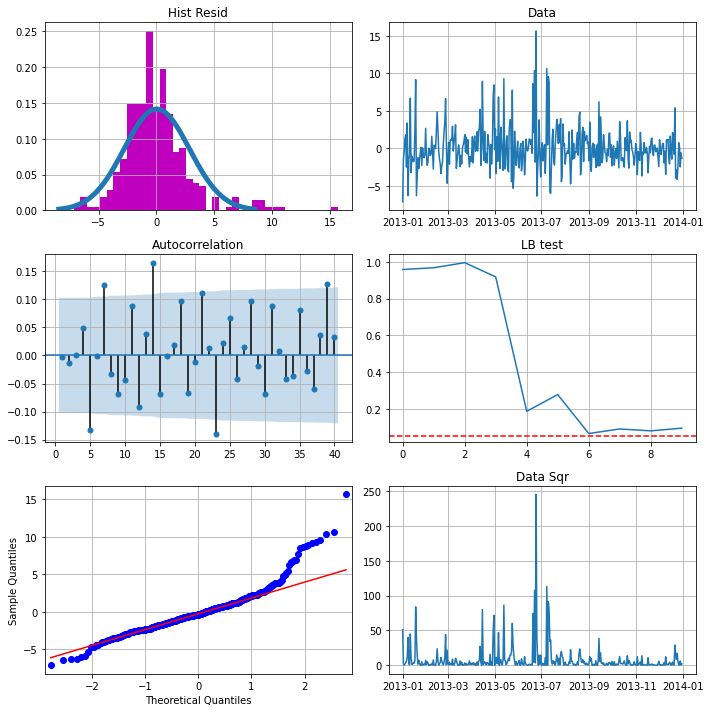

In [122]:
model = ARIMA(price, order=(1,0,1), exog = df[['w1','w2','x1','x2','x3','x4']]) 
results = model.fit( trend = 'nc') #Notice that since we added a constant to X1, need to set trend 'nc', else remove from regressor
print(results.summary());
y_fitted = results.fittedvalues
plot_diagnosticsTight3(results.resid)

A lot of work to then generate the relevant data for future predictions
===

In [123]:
# Generate data to feed to forecast (required for exogeneous variables)
def df_sincosFit2(N):
    
    weeklyFit = np.zeros(N)
    weekly2Fit = np.zeros(N)
    yearlyFit = np.zeros(N)
    yearly2Fit = np.zeros(N)
    meanTempFit = np.zeros(N)

    for i in range(N):
        yearlyFit[i] = np.sin(2*np.pi*i/365)
        yearly2Fit[i] = np.cos(2*np.pi*i/365)
        weeklyFit[i] = np.sin(2*np.pi*i/7)
        weekly2Fit[i] = np.cos(2*np.pi*i/7)
        meanTempFit[i] = meanTempNext.values[i]
    
    x = meanTempFit
    print(len(x))
    XFit = dmatrix("cr(x, df=4)-1", {"x": x}) #already choosed knots to be equally spaced quartiles.
     
    # Create dataframe
    myList = [meanTempFit, yearlyFit, yearly2Fit, weeklyFit, weekly2Fit, XFit[:,0],XFit[:,1],XFit[:,2],XFit[:,3]]
    names = ['meanTempFit','y1Fit','y2Fit','w1Fit','w2Fit','x0','x1','x2','x3']
    myDict = dict(zip(names, myList))
    dfFit = pd.DataFrame({ key:pd.Series(value) for key, value in myDict.items()})
    return dfFit

dfFit = df_sincosFit2(20)



20


36


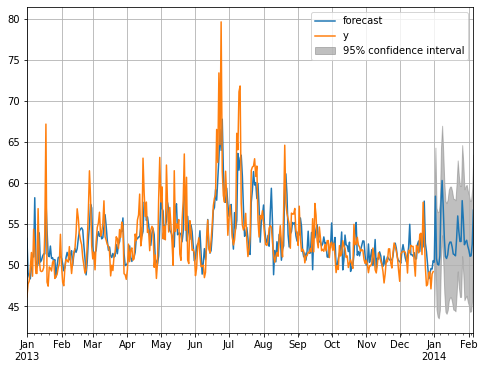

In [124]:
lastIdx = len(results.fittedvalues)
endPt = 400 
startPt = 300
nForecast = endPt - lastIdx
exog = df_sincosFit2(nForecast+1) # needs to add 20 points for external regressor to predict.

results.plot_predict(start=0,end=endPt, exog = exog[['w1Fit','w2Fit','x0','x1','x2','x3']] )
plt.grid()
plt.show()

SARIMAX - Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors model
===

In [125]:
model = SARIMAX(price, order=(1,0,1),  seasonal_order=(1, 0, 1, 7)) 
results = model.fit( trend = 'c') 
print(results.summary());
y_fitted = results.fittedvalues

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  365
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 7)   Log Likelihood                -929.266
Date:                           Wed, 25 Nov 2020   AIC                           1868.533
Time:                                   13:20:35   BIC                           1888.032
Sample:                                        0   HQIC                          1876.282
                                           - 365                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9888      0.009    112.977      0.000       0.972       1.006
ma.L1         -0.3615      0.036    -10.123

In [126]:
model = SARIMAX(price, order=(1,0,1)) 
arima_result = model.fit() 
print(arima_result.summary());
y_fitted_arima = arima_result.fittedvalues

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  365
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -949.203
Date:                Wed, 25 Nov 2020   AIC                           1904.406
Time:                        13:20:41   BIC                           1916.105
Sample:                             0   HQIC                          1909.055
                                - 365                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9992      0.002    492.159      0.000       0.995       1.003
ma.L1         -0.4014      0.032    -12.739      0.000      -0.463      -0.340
sigma2        10.4640      0.461     22.701      0.0

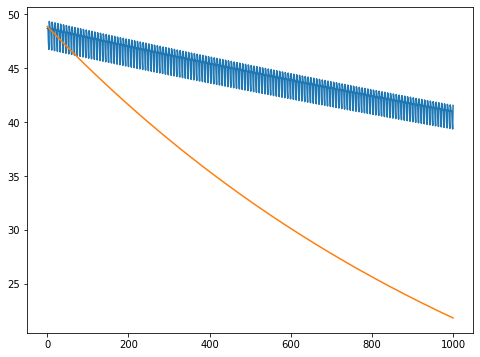

In [127]:
# But results are worth it... more realistic forecast for mean

# Create SARIMA mean forecast
sarima_pred = results.get_forecast(steps=1000)
sarima_mean = sarima_pred.predicted_mean

# Create arima mean forecast
arima_pred = arima_result.get_forecast(steps=1000)
arima_mean = arima_pred.predicted_mean

# Conf interval
sarima_pred.conf_int

# Plot mean ARIMA and SARIMA predictions and observed
plt.plot(sarima_mean, label='SARIMA')
plt.plot(arima_mean, label='ARIMA')
plt.show()

In [128]:
?sarima_pred.prediction_results
print(sarima_pred.summary_frame().head())

y       mean   mean_se  mean_ci_lower  mean_ci_upper
0  48.703824  3.027408      42.770214      54.637435
1  48.753442  3.573302      41.749898      55.756987
2  48.650346  4.035997      40.739937      56.560754
3  47.427998  4.441769      38.722290      56.133706
4  46.746450  4.805243      37.328347      56.164554


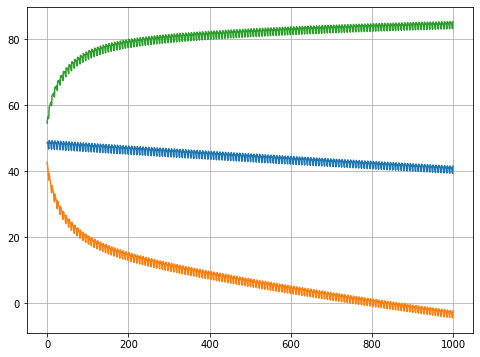

In [129]:
low = sarima_pred.summary_frame()['mean_ci_lower']
up = sarima_pred.summary_frame()['mean_ci_upper']
mean = sarima_pred.summary_frame()['mean']

plt.plot(mean) 
plt.plot(low) 
plt.plot(up) 
plt.grid()
plt.show()

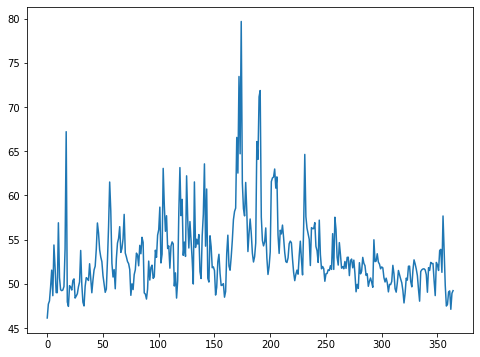

In [130]:
plt.plot(price)

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  365
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 7)   Log Likelihood                -881.698
Date:                           Wed, 25 Nov 2020   AIC                           1781.396
Time:                                   13:21:30   BIC                           1816.495
Sample:                               01-01-2013   HQIC                          1795.345
                                    - 12-31-2013                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            59.8663      1.485     40.308      0.000      56.955      62.777
x2            51.8547      1.388     37.362

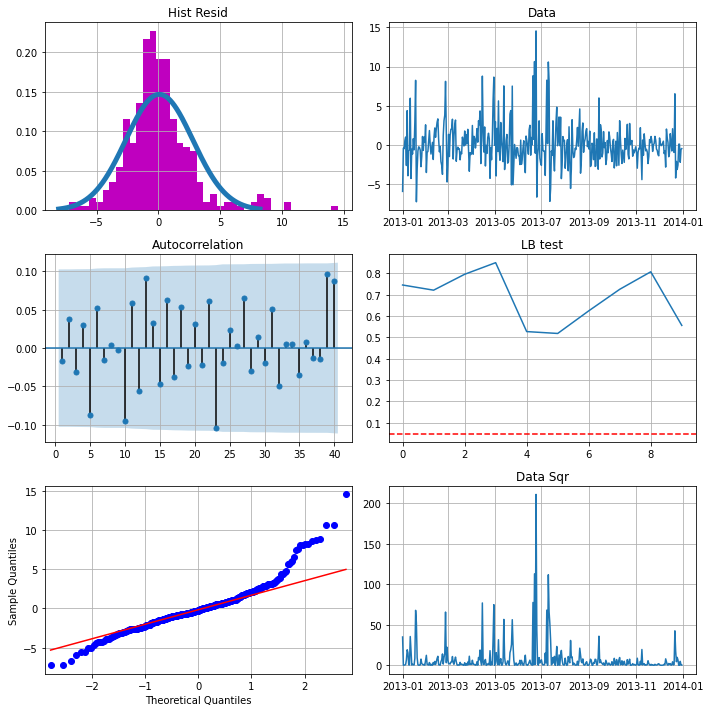

In [132]:
model = SARIMAX(price, order=(1,0,1),  seasonal_order=(1, 0, 1, 7), exog = df[['x1','x2','x3','x4']]) 
results = model.fit( trend = 'c') 
print(results.summary());
y_fitted = results.fittedvalues
plot_diagnosticsTight3(results.resid)

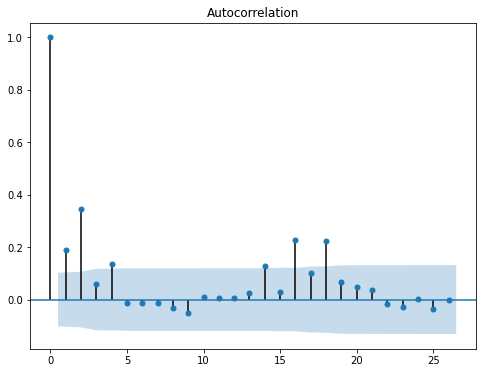

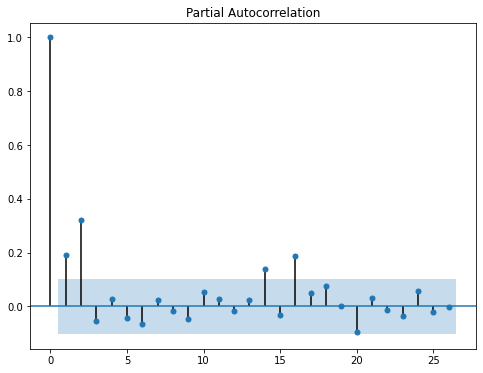

In [137]:
plot_acf(results.resid**2);
plot_pacf(results.resid**2);